In [ ]:
!pip install autokeras

In [2]:
import tensorflow as tf
import autokeras as ak

Using TensorFlow backend


# **기본 파이프라인 구성**


In [ ]:
'''
use_btchnor으로 배치정규화 사용할지 말지 선택 가능
dropout = 0.0으로 하면 drop out 비활성화
DenseBlock 의 기본값은 1~3개, 유닛 개수는 [16,32,64,128,256,512,1024]중 하나임.
'''
input_node = ak.StructuredDataInput()
output_node = ak.Normalization()(input_node)
output_node = ak.DenseBlock(use_batchnorm=False, dropout=0.0)(output_node)
output_node = ak.RegressionHead(dropout=0.0)(output_node)
auto_model = ak.AutoModel(
    inputs=input_node, outputs=output_node, max_trials=10, overwrite=True, seed=42
)

```
# 삼각형 MLP 구조를 강제하기 위해서, Dense층의 개수는 2개,
첫번째 층은 유닛의 개수를 128 256 512 1024에서 탐색하고
두번째 층은 16 32 64에서 탐색하도록 설정한다.

from keras_tuner.engine import hyperparameters as hp

input_node = ak.StructuredDataInput()
output_node = ak.Normalization()(input_node)
output_node = ak.DenseBlock(
    num_layers=1,
    num_units=hp.Choice("num_units", [128, 256, 512, 1024]),
    use_batchnorm=False,
    dropout=0.0,)(output_node)
output_node = ak.DenseBlock(
    num_layers=1,
    num_units=hp.Choice("num_units", [16, 32, 64]),
    use_batchnorm=False,
    dropout=0.0,)(output_node)
output_node = ak.RegressionHead()(output_node)
auto_model = ak.AutoModel(inputs=input_node, outputs=output_node,
                          max_trials=10, overwrite=True, seed=42)
```

In [ ]:
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
import pandas as pd

house_dataset = fetch_california_housing()
data = pd.DataFrame(house_dataset.data, columns=house_dataset.feature_names)
target = pd.Series(house_dataset.target, name="MEDV")

train_data, test_data, train_targets, test_targets = train_test_split(
    data, target, test_size=0.2, random_state=42
)

auto_model.fit(train_data, train_targets, batch_size=1024, epochs=150)

Trial 10 Complete [00h 01m 45s]
val_loss: 0.5726417303085327

Best val_loss So Far: 0.28704002499580383
Total elapsed time: 00h 10m 33s
Epoch 1/150
17/17 [==============================] - 1s 48ms/step - loss: 2.6699 - mean_squared_error: 2.6699
Epoch 2/150
17/17 [==============================] - 1s 31ms/step - loss: 0.9129 - mean_squared_error: 0.9129
Epoch 3/150
17/17 [==============================] - 1s 29ms/step - loss: 0.6719 - mean_squared_error: 0.6719
Epoch 4/150
17/17 [==============================] - 1s 31ms/step - loss: 0.5514 - mean_squared_error: 0.5514
Epoch 5/150
17/17 [==============================] - 0s 28ms/step - loss: 0.4749 - mean_squared_error: 0.4749
Epoch 6/150
17/17 [==============================] - 0s 28ms/step - loss: 0.4292 - mean_squared_error: 0.4292
Epoch 7/150
17/17 [==============================] - 1s 29ms/step - loss: 0.4028 - mean_squared_error: 0.4028
Epoch 8/150
17/17 [==============================] - 1s 30ms/step - loss: 0.3865 - mean_square

In [ ]:
#Evaluate best pipeline
test_loss, test_acc = auto_model.evaluate(test_data, test_targets, verbose=0)
print("Test accuracy: ", test_acc)

Test accuracy:  0.2736497223377228


Results summary
Results in ./auto_model
Showing 1 best trials
Objective(name="val_loss", direction="min")

Trial 03 summary
Hyperparameters:
dense_block_1/num_layers: 2
dense_block_1/units_0: 256
dense_block_1/units_1: 1024
optimizer: adam
learning_rate: 0.001
Score: 0.28704002499580383


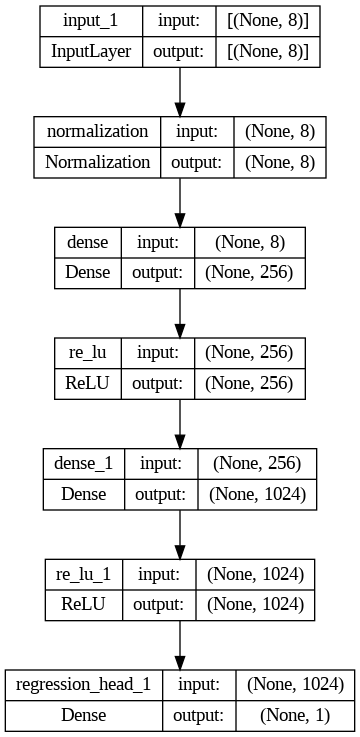

In [ ]:
#파이프 라인 시각화
auto_model.tuner.results_summary(num_trials=1)
best_model = auto_model.export_model()
tf.keras.utils.plot_model(best_model, show_shapes=True, expand_nested=True)

In [ ]:
from tensorflow import keras
#모델 저장, 및 로드
best_model.save("saved_model")
best_model = keras.models.load_model("saved_model")

# **이미지 분류를 위한 CNN 튜닝**

**ConvBlock의 하이퍼 파라미터**
1. 합성곱 블록의 개수
2. 각 블록의 합성곱 계층 개수
3. 합성곱 계층의 유형(분리합성곱 등등)
4. 합성곱 계층의 필터 개수
5. 합성곱 계층의 커널 크기
6. 최대 풀링 적용 여부
7. 드롭 아웃 적용 여부

In [ ]:
from tensorflow.keras.datasets import mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()
print("Training image shape:", x_train.shape)  # (60000, 28, 28)
print("Training label shape:", y_train.shape)  # (60000,)

In [ ]:
from kerastuner.engine import hyperparameters as hp

input_node = ak.ImageInput()
output_node = ak.Normalization()(input_node)
#ConvBlock을 아래와 같이 상세하게 조정한다.
output_node = ak.ConvBlock(num_blocks=2,
                           max_pooling=True,
                           separable=False,
                           dropout=0.0)(output_node)
output_node = ak.ClassificationHead(dropout=0.0)(output_node)
auto_model = ak.AutoModel(inputs=input_node, outputs=output_node,
                          max_trials=10, overwrite=True, seed=42)

auto_model.fit(x_train[:100], y_train[:100], epochs=3)

'''
ak.ResNetBlock()
ak.XceptionBlock()
ak.InceptionBlock()
ak.ImageAugmentation()
등등 다양한 블록이 있다
'''

**이미지 블록**

In [ ]:
input_node = ak.ImageInput()
#이렇게 이미지 블록을 지정할 수 있는데 이 안에는 일반 CNN,Resnet,Xception
#등이 안에 들어있다, but 모델들이 무거워서 탐색 과정에서 자원을 많이
#소요할 뿐더러, 간단한 CNN 모델보다 무조건 낫다고 보장할 수도
output_node = ak.ImageBlock(
    normalize = True,
    augment = False,)(input_node)
output_node = ak.ClassificationHead(dropout=0.0)(output_node)
auto_model = ak.AutoModel(inputs=input_node, outputs=output_node,
                          max_trials=10, overwrite=True, seed=42)

**데이터 증강**

In [ ]:
from tensorflow.keras.datasets import cifar10

(x_train, y_train), (x_test, y_test) = cifar10.load_data()

airplane_automobile_indices_train = (y_train[:, 0] == 0) | (y_train[:, 0] == 1)
airplane_automobile_indices_test = (y_test[:, 0] == 0) | (y_test[:, 0] == 1)
x_train, y_train = (
    x_train[airplane_automobile_indices_train],
    y_train[airplane_automobile_indices_train],
)
x_test, y_test = (
    x_test[airplane_automobile_indices_test],
    y_test[airplane_automobile_indices_test],
)

170498071/170498071 [==============================] - 4s 0us/step


In [ ]:
# 이렇게 쓰거나..
input_node = ak.ImageInput()
x = ak.Normalization()(input_node)
x = ak.ImageAugumentation()(x)
x = ak.ResNetBlock(version = 'v2')(x)
output_node = ak.ClassificationHead()(x)
auto_model = ak.AutoModel(inputs=input_node, outputs=output_node,
                          max_trials=10, overwrite=True, seed=42)

In [ ]:
# 이렇게 쓸 수도 있다.
input_node = ak.ImageInput()
x = ak.ImageBlock(
    normalize = True,
    augment = True,
    block_type = 'resnet')(input_node)
output_node = ak.ClassificationHead()(x)
auto_model = ak.AutoModel(inputs=input_node, outputs=output_node,
                          max_trials=10, overwrite=True, seed=42)

# **그래프 구조의 AutoML 파이프라인**

다중 입/출력 파이프라인을 더욱 직관적으로 구성하기 위해서는 어떻게 해야할까?

In [ ]:
# 가짜 데이터 만들기
import numpy as np

num_instances = 1000

# 이미지 데이터 생성
image_data = np.random.rand(num_instances, 32, 32, 3).astype(np.float32)
image_train, image_test = image_data[:800], image_data[800:]

# 정형 데이터 생성
structured_data = np.random.choice(["a", "b", "c", "d", "e"], size=(num_instances, 3))
structured_train, structured_test = structured_data[:800], structured_data[800:]


# 5개의 범주에 대한 분류 레이블
classification_target = np.random.randint(5, size=num_instances)
clf_target_train, clf_target_test = (
    classification_target[:800],
    classification_target[800:],
)

# 회귀 레이블
regression_target = np.random.rand(num_instances, 1).astype(np.float32)
reg_target_train, reg_target_test = regression_target[:800], regression_target[800:]

In [ ]:
import autokeras as ak

#왼쪽 블럭
input_node1 = ak.ImageInput()
branch1 = ak.Normalization()(input_node1)
branch1 = ak.ConvBlock()(branch1)

#오른쪽 블럭
input_node2 = ak.StructuredDataInput()
branch2 = ak.CategoricalToNumerical()(input_node2)
branch2 = ak.DenseBlock()(branch2)

#두 블럭을 합치고
merge_node = ak.Merge()([branch1, branch2])

#출력은 두 개로 내놓는다.
output_node1 = ak.ClassificationHead()(merge_node)
output_node2 = ak.RegressionHead()(merge_node)


auto_model = ak.AutoModel(
    inputs=[input_node1, input_node2],
    outputs=[output_node1, output_node2],
    max_trials=3,
    overwrite=True,
    seed=42,
)

auto_model.fit(
    [image_train, structured_train],
    [clf_target_train, reg_target_train],
    epochs=3,
)

Trial 3 Complete [00h 00m 14s]
val_loss: 1.6831433773040771

Best val_loss So Far: 1.6831433773040771
Total elapsed time: 00h 00m 34s
Epoch 1/3
25/25 [==============================] - 3s 59ms/step - loss: 1.7862 - classification_head_1_loss: 1.6276 - regression_head_1_loss: 0.1586 - classification_head_1_accuracy: 0.2000 - regression_head_1_mean_squared_error: 0.1586
Epoch 2/3
25/25 [==============================] - 2s 89ms/step - loss: 1.6948 - classification_head_1_loss: 1.6087 - regression_head_1_loss: 0.0861 - classification_head_1_accuracy: 0.2313 - regression_head_1_mean_squared_error: 0.0861
Epoch 3/3
25/25 [==============================] - 2s 96ms/step - loss: 1.6804 - classification_head_1_loss: 1.5993 - regression_head_1_loss: 0.0811 - classification_head_1_accuracy: 0.2562 - regression_head_1_mean_squared_error: 0.0811


In [ ]:
best_model = auto_model.export_model()
best_model.summary()

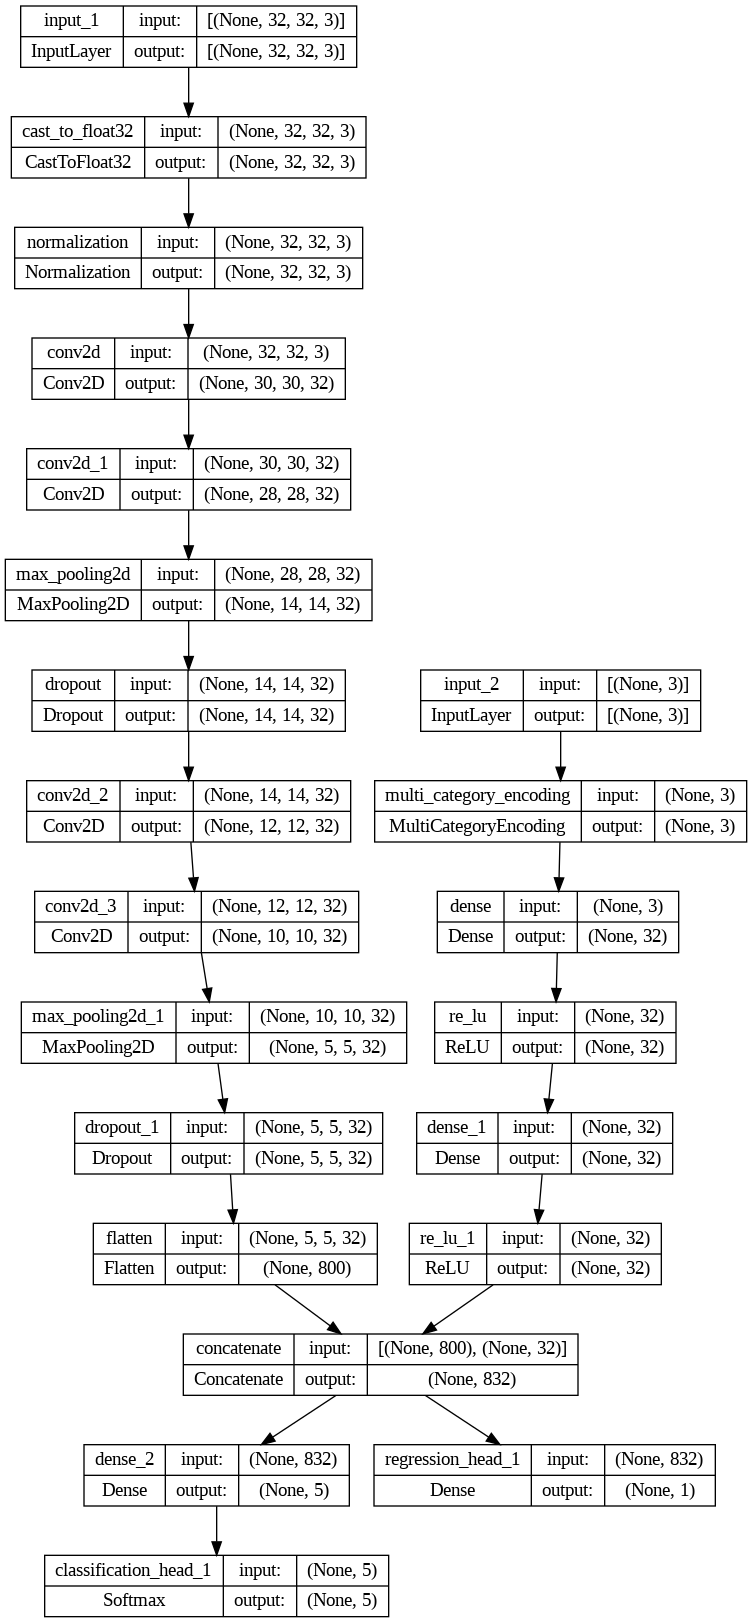

In [ ]:
tf.keras.utils.plot_model(
    best_model, show_shapes=True, expand_nested=True
)  # rankdir='LR'

'''
입력을 두 개로 받아서 중간에 합쳐지고 2개의 출력을 내놓는 것을 볼 수 있다.
병합 방식을 지정하지 않으면 훈련 과정에서 자동으로 선택된다.
'''

In [ ]:
total_loss, clf_loss, reg_loss, clf_acc, reg_mse = auto_model.evaluate(
    [image_test, structured_test],
    [clf_target_test, reg_target_test],
)

# **사용자 정의 AutoML 파이프라인**

In [ ]:
'''
사용자 정의 블록을 구성하고 싶다면 아래와 같이 ak.Block을 상속하는
클래스를 구현하여 정의하면 된다. 이것은 kerastuner와 비슷하다.

#사용 예시

계층별 유닛 개수 [10,30,50,70,90] / hp.Choice, hp.Int
계층 개수 [1,2,3,4,5] / hp.Choice, hp.Int
드롭아웃 사용 여부 [True, False] / hp.Boolean
드롭아웃 확률 [0.1, 0.2, 0.3, 0.4, 0.5] / hp.Float
'''
import autokeras as ak
import tensorflow as tf
from tensorflow.keras import layers


class MlpBlock(ak.Block): # ak.Block 상속
    def build(self, hp, inputs):
        units = hp.Int(name="units", min_value=32, max_value=512, step=32)

        input_node = tf.nest.flatten(inputs)[0]
        x = layers.Dense(units=units, activation="relu")(input_node)
        output_node = layers.Dense(units=units, activation="relu")(x)

        return output_node # 항상 출력은 output_node

#만약 2개 층의 유닛 개수를 다르게 지정하고 싶다면 이렇게 하면 된다.
class MlpBlock2(ak.Block):
    def build(self, hp, inputs):
        units_1 = hp.Int(name="units_1", min_value=32, max_value=512, step=32)
        units_2 = hp.Int(name="units_2", min_value=32, max_value=512, step=32)

        input_node = tf.nest.flatten(inputs)[0]
        x = layers.Dense(units=units_1, activation="relu")(input_node)
        output_node = layers.Dense(units=units_2, activation="relu")(x)

        return output_node

In [ ]:
'''
다음과 같이 층의 개수, 그 층의 유닛 개수,
드롭아웃 여부와 확률을 지정할 수 있다.
'''
class MlpBlock3(ak.Block):
    def build(self, hp, inputs):
        output_node = tf.nest.flatten(inputs)[0]
        for i in range(hp.Choice("num_layers", [1, 2, 3])):
            #모델이 층을 구별할 수 있도록 각 층마다 이름을 부여해줘야 한다.
            output_node = layers.Dense(
                units=hp.Int("units_" + str(i), min_value=32, max_value=512, step=32),
                activation="relu",
            )(output_node)
        if hp.Boolean("dropout"):
            output_node = layers.Dropout(
                rate=hp.Float("dropout_rate", min_value = 0, max_value = 0.5)
            )(output_node)
        return output_node

In [ ]:
import keras_tuner as kt

#다음과 같은 예시로 잘 작동하는지 검증해볼 수 있다.
hp = kt.HyperParameters()
inputs = tf.keras.Input(shape=(20,))
MlpBlock().build(hp, inputs)

In [ ]:
import numpy as np

#가짜 데이터
x_train = np.random.rand(100, 20)
y_train = np.random.rand(100, 1)
x_test = np.random.rand(100, 20)

#사용자 정의 블록 MlpBlock()은 아래와 같이 사용가능하다.
input_node = ak.StructuredDataInput()
output_node = MlpBlock2()(input_node)
output_node = ak.RegressionHead()(output_node)
auto_model = ak.AutoModel(input_node, output_node, max_trials=3, overwrite=True)
auto_model.fit(x_train, y_train, epochs=1)

In [ ]:
auto_model.tuner.search_space_summary()

Search space summary
Default search space size: 5
mlp_block2_1/units_1 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': 'linear'}
mlp_block2_1/units_2 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': 'linear'}
regression_head_1/dropout (Choice)
{'default': 0, 'conditions': [], 'values': [0.0, 0.25, 0.5], 'ordered': True}
optimizer (Choice)
{'default': 'adam', 'conditions': [], 'values': ['adam', 'sgd', 'adam_weight_decay'], 'ordered': False}
learning_rate (Choice)
{'default': 0.001, 'conditions': [], 'values': [0.1, 0.01, 0.001, 0.0001, 2e-05, 1e-05], 'ordered': True}


**그렇다면 여러 모델을 탐색해보고 싶을때는 어떻게 할까?**

In [3]:
from tensorflow.keras.datasets import cifar10

class DenseNetBlock(ak.Block):
    def build(self, hp, inputs):
        version = hp.Choice("version", ["DenseNet121", "DenseNet169", "DenseNet201"])
        if version == "DenseNet121":
            dense_net_func = tf.keras.applications.DenseNet121
        elif version == "DenseNet169":
            dense_net_func = tf.keras.applications.DenseNet169
        elif version == "DenseNet201":
            dense_net_func = tf.keras.applications.DenseNet201
        return dense_net_func(include_top=False, weights=None)(inputs)

class SelectionBlock(ak.Block):
    def build(self, hp, inputs):
        if hp.Choice("model_type", ["densenet", "resnet"]) == "densenet":
            #hp.conditional_scope로 각 모델에 맞는 하이퍼파라미터를 튜닝하게 함.
            with hp.conditional_scope("model_type", ["densenet"]):
                outputs = DenseNetBlock().build(hp, inputs)
        else:
            with hp.conditional_scope("model_type", ["resnet"]):
                outputs = ak.ResNetBlock().build(hp, inputs)
        return outputs

input_node = ak.ImageInput()
output_node = SelectionBlock()(input_node)
output_node = ak.ClassificationHead()(output_node)
auto_model = ak.AutoModel(input_node, output_node, max_trials=5, overwrite=True)

(x_train, y_train), (x_test, y_test) = cifar10.load_data()
auto_model.fit(x_train[:100], y_train[:100], epochs=1)

Trial 5 Complete [00h 00m 48s]
val_loss: 3.387059211730957

Best val_loss So Far: 1.8172193765640259
Total elapsed time: 00h 02m 44s


4/4 [==============================] - 35s 782ms/step - loss: 2.6475 - accuracy: 0.0600


# **완전한 사용자 정의 AutoML(전처리,모델,파라미터) with KerasTuner**

In [15]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras_tuner import RandomSearch

#build_model 안에 모델을 구축한다.
def build_model(hp):
    input_node = keras.Input(shape = (20,))
    #유닛 개수 튜닝
    units = hp.Int("units", min_value = 32, max_value = 256, step = 32)
    x = layers.Dense(units = units, activation = "relu")(input_node)
    x = layers.Dense(units = units, activation = "relu")(x)
    output_node = layers.Dense(units = 1, activation = "sigmoid")(x)
    model = keras.Model(input_node, output_node)

    #옵티마이저도 튜닝 가능하다.
    optimizer_name = hp.Choice("optimizer", ["adam", "RMSprop"])
    learning_rate = hp.Float("learning_rate", min_value=1e-5, max_value=0.1, sampling="log")
    if optimizer_name == "adam":
        optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    else:
        optimizer = tf.keras.optimizers.RMSprop(learning_rate=learning_rate)

    #모델 컴파일
    model.compile(optimizer = optimizer,
                  loss = "mse",
                  metrics = ["mae"])
    return model

tuner = RandomSearch(
    build_model,
    objective = "val_mae",
    max_trials = 10,
    executions_per_trial = 2,
    directory = '/content',
    project_name = "Randomsearch_to_kt")

tuner.search_space_summary()

Reloading Tuner from /content/hyperband_to_kt/tuner0.json
Search space summary
Default search space size: 3
units (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 256, 'step': 32, 'sampling': 'linear'}
optimizer (Choice)
{'default': 'adam', 'conditions': [], 'values': ['adam', 'RMSprop'], 'ordered': False}
learning_rate (Float)
{'default': 1e-05, 'conditions': [], 'min_value': 1e-05, 'max_value': 0.1, 'step': None, 'sampling': 'log'}


In [14]:
import numpy as np

#가짜 데이터
x_train = np.random.rand(100, 20)
y_train = np.random.rand(100, 1)
x_val = np.random.rand(20, 20)
y_val = np.random.rand(20, 1)

#search메서드를 fit과 동일하게 생각하면 됨. epoch는 각 선택한 모델을 얼마나 훈련시킬지.
tuner.search(x_train, y_train, epochs=1, validation_data=(x_val, y_val))

In [ ]:
#모델 저장

best_models = tuner.get_best_models(num_models=2) #최상의 모델 몇개를 저장할지
best_model = best_models[0] # 가장 최선의 모델
best_model.save("path_to_best_model")
best_model = keras.models.load_model("path_to_best_model")
print(best_model.predict(x_val))
best_model.summary()

## **모델의 학습 과정 튜닝하기(Hypermodel Class)**

In [16]:
import keras_tuner as kt

class Regressor(kt.HyperModel):
    def build(self, hp):
        input_node = keras.Input(shape=(20,))
        units = hp.Int("units", min_value=32, max_value=512, step=32)
        output_node = layers.Dense(units=units, activation="relu")(input_node)
        output_node = layers.Dense(units=units, activation="relu")(output_node)
        output_node = layers.Dense(units=1, activation="sigmoid")(output_node)
        model = keras.Model(input_node, output_node)

        optimizer_name = hp.Choice("optimizer", ["adam", "adadelta"])
        learning_rate = hp.Float(
            "learning_rate", min_value=1e-5, max_value=0.1, sampling="log")
        if optimizer_name == "adam":
            optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
        else:
            optimizer = tf.keras.optimizers.Adadelta(learning_rate=learning_rate)

        model.compile(optimizer=optimizer, loss="mse", metrics=["mae"])
        return model

    def fit(self, hp, model, **kwargs):
        return model.fit(
            batch_size=hp.Int("batch_size"), #배치 크기 튜닝
            shuffle=hp.Boolean("shuffle"), # 데이터셋 셔플링 여부
            **kwargs)

tuner = RandomSearch(
    build_model,
    objective="val_mae", #사용자 정의 지표 사용시 direction을 설정해야함.
    max_trials=5,
    executions_per_trial=3,
    directory="/content",
    project_name="helloworld",
)

In [ ]:
tuner = RandomSearch(Regressor(), objective="val_loss", max_trials=2)
tuner.search(x_train, y_train, validation_data=(x_val, y_val))

### **전처리**

In [ ]:
# 모델의 전처리도 추가할 수 있다.
from tensorflow.keras.layers import Normalization

#일반적인 사용법은 아래와 같다.
layer = Normalization(input_shape=(20,))
layer.adapt(x_train)

model = tf.keras.Sequential([layer, tf.keras.layers.Dense(1)])
model.compile(optimizer="adam", loss="mse")
model.fit(x_train, y_train)

#아니면 이렇게 쓸 수도 있다
normalized_x_train = layer(x_train) #adapt없이 바로 사용

#또 아니면 data.api에서 파일을 불러오고 map을 통해 전처리 할 수도 있다.
dataset_x_train = tf.data.Dataset.from_tensor_slices(x_train).batch(32)
normalized_dataset = dataset_x_train.map(layer)

#아래와 같이 사용해서 정규화 층을 사용할지 말지 등을 정할수도 있음
from keras_tuner import HyperModel

class Regressor(HyperModel):
    def build(self, hp):
        model = tf.keras.Sequential()
        model.add(tf.keras.layers.Dense(1))
        model.compile(optimizer="adam", loss="mse")
        return model

    def fit(self, hp, model, x, y, **kwargs):
        if hp.Boolean("normalize"):
            layer = Normalization(input_shape=(20,))
            layer.adapt(x)
            x = layer(x)
        return model.fit(x=x, y=y, **kwargs)

tuner = RandomSearch(Regressor(), objective="val_loss", max_trials=2)
tuner.search(x_train, y_train, validation_data=(x_val, y_val))

# **AutoEncoder 모델 튜닝**

In [18]:
#Mnist 이미지를 오토인코더에 넣어보자

from tensorflow.keras.datasets import fashion_mnist

(x_train, _), (x_test, _) = fashion_mnist.load_data()

#먼저 데이터를 0~1로 만들어주고
x_train = x_train.astype("float32") / 255.0
x_test = x_test.astype("float32") / 255.0

4422102/4422102 [==============================] - 0s 0us/step


In [19]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras import layers, losses

#오토 인코더를 구현한다
class AutoencoderModel(Model):
    def __init__(self, latent_dim):
        super().__init__()
        self.latent_dim = latent_dim
        self.encoder_layer = layers.Dense(latent_dim, activation="relu")
        self.decoder_layer = layers.Dense(784, activation="sigmoid")

    def encode(self, encoder_input):
        encoder_output = layers.Flatten()(encoder_input)
        encoder_output = self.encoder_layer(encoder_output)
        return encoder_output

    def decode(self, decoder_input):
        decoder_output = decoder_input
        decoder_output = self.decoder_layer(decoder_output)
        decoder_output = layers.Reshape((28, 28))(decoder_output)
        return decoder_output

    def call(self, x):
        return self.decode(self.encode(x))

In [ ]:
import numpy as np

#오토 인코더를 훈련하고
tf.random.set_seed(5)
np.random.seed(5)
autoencoder = AutoencoderModel(64)
autoencoder.compile(optimizer="adam", loss="mse")
autoencoder.fit(
    x_train, x_train, epochs=10, shuffle=True, validation_data=(x_test, x_test)
)

autoencoder.evaluate(x_test, x_test)

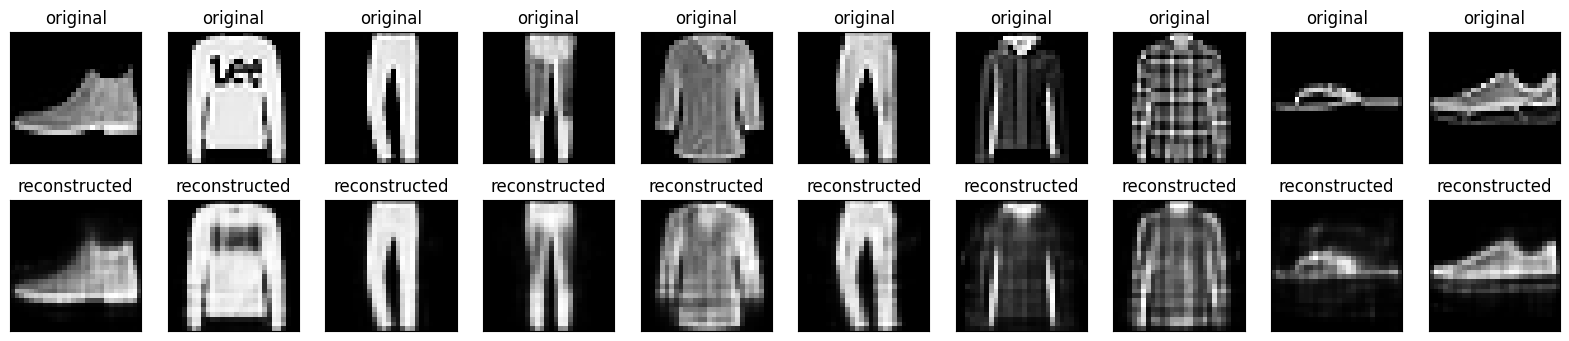

In [21]:
import matplotlib.pyplot as plt

#이를 시각화해본다.
def show_images(model, images):
    encoded_imgs = model.encode(images).numpy()
    decoded_imgs = model.decode(encoded_imgs).numpy()

    n = 10
    plt.figure(figsize=(20, 4))
    for i in range(n):
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(images[i])
        plt.title("original")
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(decoded_imgs[i])
        plt.title("reconstructed")
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()


show_images(autoencoder, x_test)

In [23]:
import keras_tuner
from tensorflow import keras
from keras_tuner import RandomSearch
'''
1. 인코딩(디코딩) 레이어는 몇개로 할지
2. 각 층의 유닛 개수는 몇개로 할지 + 각각 다른 이름 지정
'''
class AutoencoderBlock(keras.Model):
    def __init__(self, latent_dim, hp):
        super().__init__()
        self.latent_dim = latent_dim

        #인코딩 레이어
        self.encoder_layers = []
        for i in range(
            #레이어 개수
            hp.Int("encoder_layers", min_value=0, max_value=2, step=1,
                   default=0)):
            #유닛 이름 및 유닛 개수
            self.encoder_layers.append(layers.Dense(
                units=hp.Choice("encoder_layers_{i}".format(i=i),
                                [64, 128, 256]),activation="relu",))
        self.encoder_layers.append(layers.Dense(latent_dim, activation="relu"))

        #디코딩 레이어
        self.decoder_layers = []
        for i in range(hp.Int("decoder_layers", min_value=0, max_value=2, step=1,
                              default=0)):
            self.decoder_layers.append(layers.Dense(
                units=hp.Choice("decoder_layers_{i}".format(i=i),
                                [64, 128, 256]),activation="relu",))
        self.decoder_layers.append(layers.Dense(784, activation="sigmoid"))
    '''
    기존 코드
    encoder_output = self.encoder_layer(encoder_output)가
    for layer in self.encoder_layers:
        encoder_output = layer(encoder_output) 로 바뀐 것
    '''
    def encode(self, encoder_input):
        encoder_output = layers.Flatten()(encoder_input)
        for layer in self.encoder_layers:
            encoder_output = layer(encoder_output)
        return encoder_output

    def decode(self, decoder_input):
        decoder_output = decoder_input
        for layer in self.decoder_layers:
            decoder_output = layer(decoder_output)
        decoder_output = layers.Reshape((28, 28))(decoder_output)
        return decoder_output

    def call(self, x):
        return self.decode(self.encode(x))


In [ ]:
def build_model(hp):
    latent_dim = 20
    autoencoder = AutoencoderBlock(latent_dim, hp)
    autoencoder.compile(optimizer="adam", loss="mse")
    return autoencoder

tuner = RandomSearch(
    build_model,
    objective="val_loss",
    max_trials=10,
    overwrite=True,
    directory="my_dir",
    project_name="helloworld",
)

tuner.search(x_train, x_train, epochs=10, validation_data=(x_test, x_test))
autoencoder = tuner.get_best_models(num_models=1)[0]
tuner.results_summary(1)
autoencoder.evaluate(x_test, x_test)

show_images(autoencoder, x_test)
#그닥 더 좋진 않은듯..